In [2]:
#| default_exp training

In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [4]:
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Basic training loop
Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [7]:
loss_func = F.cross_entropy

In [8]:
n, m = x_train.shape
c = y_train.max() + 1
nh=50
n,m,c, nh

(50000, 784, tensor(10), 50)

In [9]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [10]:
model = Model(m, nh, 10)
pred = model(x_train)
pred

tensor([[-0.09, -0.21, -0.08,  ..., -0.03,  0.01,  0.06],
        [-0.07, -0.14, -0.14,  ...,  0.03,  0.04,  0.14],
        [-0.19, -0.04,  0.02,  ..., -0.01, -0.00,  0.02],
        ...,
        [-0.03, -0.22, -0.04,  ..., -0.01,  0.09,  0.14],
        [-0.10, -0.09, -0.05,  ..., -0.01,  0.02,  0.11],
        [-0.03, -0.25, -0.06,  ...,  0.00,  0.03,  0.14]], grad_fn=<AddmmBackward0>)

In [11]:
bs = 50

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [12]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [13]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [14]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [15]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [16]:
accuracy(preds, yb)

tensor(0.08)

In [17]:
lr = 0.5
epochs = 3 

In [18]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [19]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


## Using parameters and Optim
### Parameters

In [20]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [21]:
m1.named_children(), list(m1.named_children())

(<generator object Module.named_children at 0x7f74cd5319a0>,
 [('foo', Linear(in_features=3, out_features=4, bias=True))])

In [22]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [23]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [24]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [25]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [26]:
for name, l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [27]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [28]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [29]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


Behind the scenes, PyTorch overides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [30]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()     # [Equivalent] for p in l.parameters: yield p

In [31]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [32]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

In [33]:
from functools import reduce

We can use the orignal `layers` approach, byt we have to register the modules

In [34]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [35]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        # add__module method is used for making pytorch acknowledge the layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        

    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [36]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [37]:
model(xb).shape

torch.Size([50, 10])

## nn.ModuleList
`nn.ModuleList` does this for us.

In [38]:
class SequentialModel(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        # Module list performs add_module method over list of layers

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x    

In [39]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [40]:
fit()

0.12, 0.96
0.11, 0.96
0.07, 0.98


### nn.Sequential
It is a pytorch class which performs the above feature

In [41]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [42]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.15, 0.96
0.11, 0.96
0.09, 0.94


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

In [43]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [44]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [45]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [46]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [47]:
opt = Optimizer(model.parameters())

In [48]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


Pytorch provides exact same functionality with optim.SGD. It also handles momentum which we'll look later.

In [49]:
from torch import optim

In [50]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [51]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [52]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


### Dataset & Dataloaders
Dataset
It's clunky to iterate through minibatches of x and y values separately:

xb = x_train[s]
    yb = y_train[s]
Instead, let's do these two steps together, by introducing a Dataset class:

xb,yb = train_ds[s]

In [53]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [54]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [55]:
xb, yb = train_ds[:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)

In [56]:
model, opt = get_model()

In [57]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = train_ds[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


## DataLoader
Previously, our loop iterated over batches (xb, yb) like this:
```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:\n,
```python
for xb,yb in train_dl:
    ...
```

In [58]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i: i+self.bs]

In [59]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [60]:
xb, yb = next(iter(train_dl))
xb.shape

torch.Size([50, 784])

tensor(5)

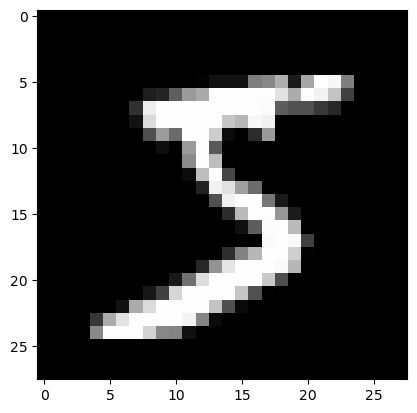

In [61]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [62]:
model, opt = get_model()

In [63]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [64]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.98
0.09, 0.98
0.06, 1.00


(tensor(0.16, grad_fn=<NllLossBackward0>), tensor(0.96))

## Random Sampling 
We want our training set to be in a random order, and that order should be differ each iteraction. But the validation set shouldn't be randomized

In [65]:
import random

In [66]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [67]:
from itertools import islice

In [68]:
ss = Sampler(train_ds)

In [69]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [70]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [71]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[29514, 4989, 30672, 9154, 6400]

In [72]:
import fastcore.all as fc

In [73]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [74]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[6954, 29540, 39446, 7727],
 [44116, 48010, 9656, 36688],
 [6829, 4606, 11492, 29492],
 [25810, 41040, 10302, 39223],
 [14991, 9516, 25680, 22961]]

In [75]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [76]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [77]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [78]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(9)

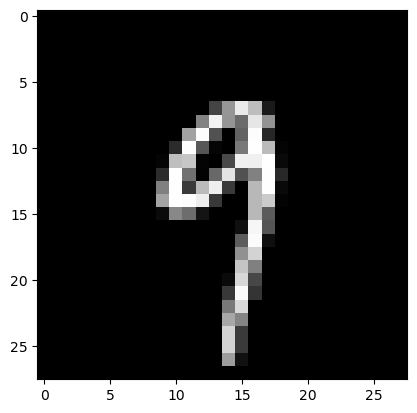

In [79]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [80]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [81]:
model, opt = get_model()
fit()

0.14, 0.96
0.27, 0.92
0.21, 0.92


## Multiprocessing Dataloader

In [82]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [83]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [84]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [85]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [86]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex:
            yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [87]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [88]:
xb, yb= next(it)
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/agastya/mambaforge/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/agastya/mambaforge/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/agastya/mambaforge/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/agastya/mambaforge/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/agastya/mambaforge/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/agastya/mambaforge/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/agastya/mambaforge/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/agastya/mambafo

## PyTorch DataLoader

In [89]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [90]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [91]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn = collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn = collate)

In [92]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.96
0.11, 0.96
0.25, 0.98


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

#### Automatic generation of batchsampler

In [93]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

#### Automatic generation of random and sequential sampler

In [94]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)


In [95]:
model, opt = get_model()

In [96]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.21, 0.92
0.15, 0.94
0.05, 0.98


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

Our dataset actually already knows how to sample a batch of indices all at once:

In [97]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [98]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [99]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation
You always should also have a validation set, in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)


In [100]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count= 0., 0., 0.
            for xb, yb in valid_dl:
                preds = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(preds, yb).item() * n
                tot_acc += accuracy(preds, yb).item() * n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [101]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs, **kwargs))

In [102]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()

In [103]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 11.298286051750184 0.958100000321865
1 11.298286051750184 0.9631999990344048
2 11.298286051750184 0.96450000166893
3 11.298286051750184 0.9670000004768372
4 11.298286051750184 0.9678000006079673
CPU times: user 12 s, sys: 9.54 s, total: 21.6 s
Wall time: 5.39 s


#### Export


In [104]:
import nbdev; nbdev.nbdev_export()